In [1]:
import os, glob
import numpy as np
import numpy.linalg as la
import numpy.random as rand
import scipy.stats as stats
import cv2 as cv
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import model_selection as slms, preprocessing as spre
from skimage import measure as meas, feature as feat
from tqdm import tnrange, tqdm_notebook as tqdm
from jupyterthemes import jtplot

C:\Users\MaryChrisGo\Anaconda3\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\MaryChrisGo\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\Users\MaryChrisGo\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
# ban_a, app_a, ora_a = np.load('astar-ban_app_ora.npy')
# ban_b, app_b, ora_b = np.load('bstar-ban_app_ora.npy')
# ban_e, app_e, ora_e = np.load('ecc-ban_app_ora.npy')

In [3]:
train = 'C://Users//MaryChrisGo//Documents//1st Sem AY 2019-2020//App Physics 186//Act_12//'
banana = train + 'Banana//'
mango = train + 'Mango//'
orange = train + 'Orange//'

In [4]:
ban_a, ban_b, ban_ecc = [], [], []
man_a, man_b, man_ecc = [], [], []
ora_a, ora_b, ora_ecc = [], [], []
ass = [ban_a, man_a, ora_a]
bss = [ban_b, man_b, ora_b]
ecs = [ban_ecc, man_ecc, ora_ecc]
dirs = [banana, mango, orange]

for j in range(3):
    filenames = os.listdir(dirs[j])
    for i,f in enumerate(filenames):
        if i == 50:
            break 
        #eccentricity
        img = cv.imread(dirs[j] + f)
        img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        thres, out = cv.threshold(img_gray, 127, 255, cv.THRESH_OTSU)
        out = (img_gray < thres).astype(float)
        img_label = meas.label(out)
        props = meas.regionprops(img_label)
        ecc = props[0]['eccentricity']

        # a* b*
        img_Lab = cv.cvtColor(img, cv.COLOR_BGR2Lab).astype(float)
        img_Lab /= img_Lab[:,:,0].max()
        img_L, img_a, img_b = cv.split(img_Lab)

        ass[j].append(img_a.mean())
        bss[j].append(img_b.mean())
        ecs[j].append(ecc)


C:\Users\MaryChrisGo\Anaconda3\lib\site-packages\skimage\measure\_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
C:\Users\MaryChrisGo\Anaconda3\lib\site-packages\skimage\measure\_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


In [5]:
ban_features = np.array([ban_a, ban_b, ban_ecc]).T
man_features = np.array([man_a, man_b, man_ecc]).T
ora_features = np.array([ora_a, ora_b, ora_ecc]).T

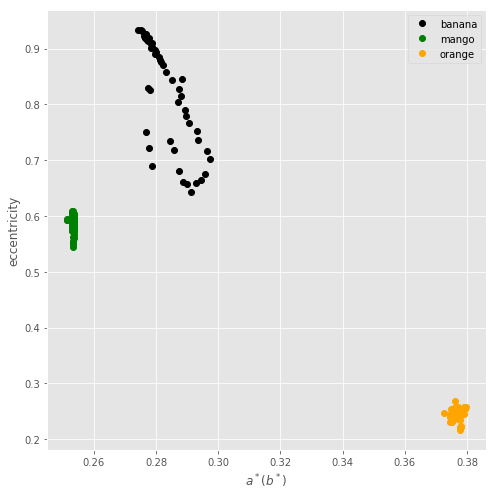

[0.28839511 0.27421662 0.27525857 0.27796927 0.27548811 0.27665427
 0.27646894 0.27623475 0.27729346 0.27682766 0.27648563 0.27771409
 0.27737453 0.27708894 0.27751618 0.2787604  0.27833777 0.2787265
 0.27831899 0.27965183 0.27998211 0.27958643 0.28085357 0.28131056
 0.28170495 0.28229551 0.28313763 0.28516368 0.28752009 0.28798774
 0.28704885 0.28925858 0.28962731 0.29049464 0.29302367 0.29360147
 0.29646488 0.2974998  0.29566739 0.2943785  0.29285862 0.29139864
 0.29000731 0.28873765 0.28733796 0.28590862 0.28437933 0.27690172
 0.277847   0.27875768]


In [6]:
banana_ab = np.multiply(ban_b, ban_a)
mango_ab = np.multiply(man_b, man_a)
orange_ab = np.multiply(ora_b, ora_a)

plt.style.use('ggplot')
plt.figure(figsize=(7, 7))
plt.plot(banana_ab, ban_ecc, 'o', color = 'black', label='banana')
plt.plot(mango_ab, man_ecc, 'o', color = 'green', label='mango')
plt.plot(orange_ab, ora_ecc, 'o', color = 'orange', label='orange')
plt.xlabel('$a^*(b^*)$')
plt.ylabel('eccentricity')
plt.legend()
plt.tight_layout()
plt.savefig('be_space.png', dpi=300, bbox_inches='tight')
plt.show()

print(banana_ab)

In [7]:
class ExpectationMaximization:
    def __init__(self, n_classes,
                 dimensions,
                 baseline=0.1):
        self.n_classes = n_classes
        self.dimensions = dimensions
        self.baseline = baseline
    
    def _p(self, x, mu, sigma):
        return 1/(2*np.pi)**(self.dimensions/2)/la.det(sigma)**(1/2) \
             * np.exp(-1/2 * (x - mu).T.dot(la.inv(sigma)).dot(x - mu))
    
    def _P(self, l, x):
        num = self.P[l] * self._p(x, self.theta['mu'][l], self.theta['cov'][l])
        den = 0.
        for m in range(self.n_classes):
            den += self.P[m] * self._p(x, self.theta['mu'][m], self.theta['cov'][l])
        return num/den
    
    def train(self, X, cluster_means, epochs=int(1e6)):
        self.graph_loss = []
        self.epochs = epochs
        N = len(X)
        ll_old = 0.
        self.theta = dict({'mu': cluster_means,
                           'cov': np.array([np.identity(self.dimensions) \
                                            for _ in range(self.n_classes)])
                          })
        self.P = np.ones(self.n_classes) * 1/self.n_classes
        for count in tnrange(epochs, desc='Epoch'):
            exp_A = []
            exp_B = []
            ll_new = 0.
            ws = np.zeros((self.n_classes, N))
            
            for l in range(self.n_classes):
                for i, x in enumerate(X):
                    ws[l,i] = self.P[l] * \
                              stats.multivariate_normal(self.theta['mu'][l],
                                                        self.theta['cov'][l],
                                                       ).pdf(x)
            ws /= ws.sum(0)
            
            Pnew = np.zeros(self.n_classes)
            for l in range(self.n_classes):
                for i in range(N):
                    Pnew[l] += ws[l,i]
            Pnew /= N
            
            mu_new = np.zeros((self.n_classes, self.dimensions))
            for l in range(self.n_classes):
                for i in range(N):
                    mu_new[l] += ws[l,i] * X[i]
                mu_new[l] /= ws[l].sum()
            
            cov_new = np.zeros((self.n_classes, self.dimensions, self.dimensions))
            for l in range(self.n_classes):
                for i in range(N):
                    ys = np.reshape(X[i] - mu_new[l], (2, 1))
                    cov_new[l] += ws[l,i] * ys.dot(ys.T)
                cov_new[l] /= ws[l].sum()
            
            ll_new = 0.
            for i in range(N):
                s = 0.
                for l in range(self.n_classes):
                    s += Pnew[l] * stats.multivariate_normal(self.theta['mu'][l],
                                                             self.theta['cov'][l]
                                                            ).pdf(X[i])
                ll_new += np.log(s)
            self.graph_loss.append(ll_new)
            if abs(ll_new - ll_old) < self.baseline:
                break
            ll_old = ll_new
            
            self.P = Pnew
            self.theta['mu'] = mu_new
            self.theta['cov'] = cov_new

In [8]:
astars = np.concatenate((ban_a, man_a, ora_a))
bstars = np.concatenate((ban_b, man_b, ora_b))
X = np.column_stack((astars, bstars))
cluster_means = np.array([[np.mean(ban_a), np.mean(ban_b)],
                          [np.mean(man_a), np.mean(man_b)],
                          [np.mean(ora_a), np.mean(ora_b)]
                         ])
em = ExpectationMaximization(3, 2, baseline=1e-4)
em.train(X, cluster_means)

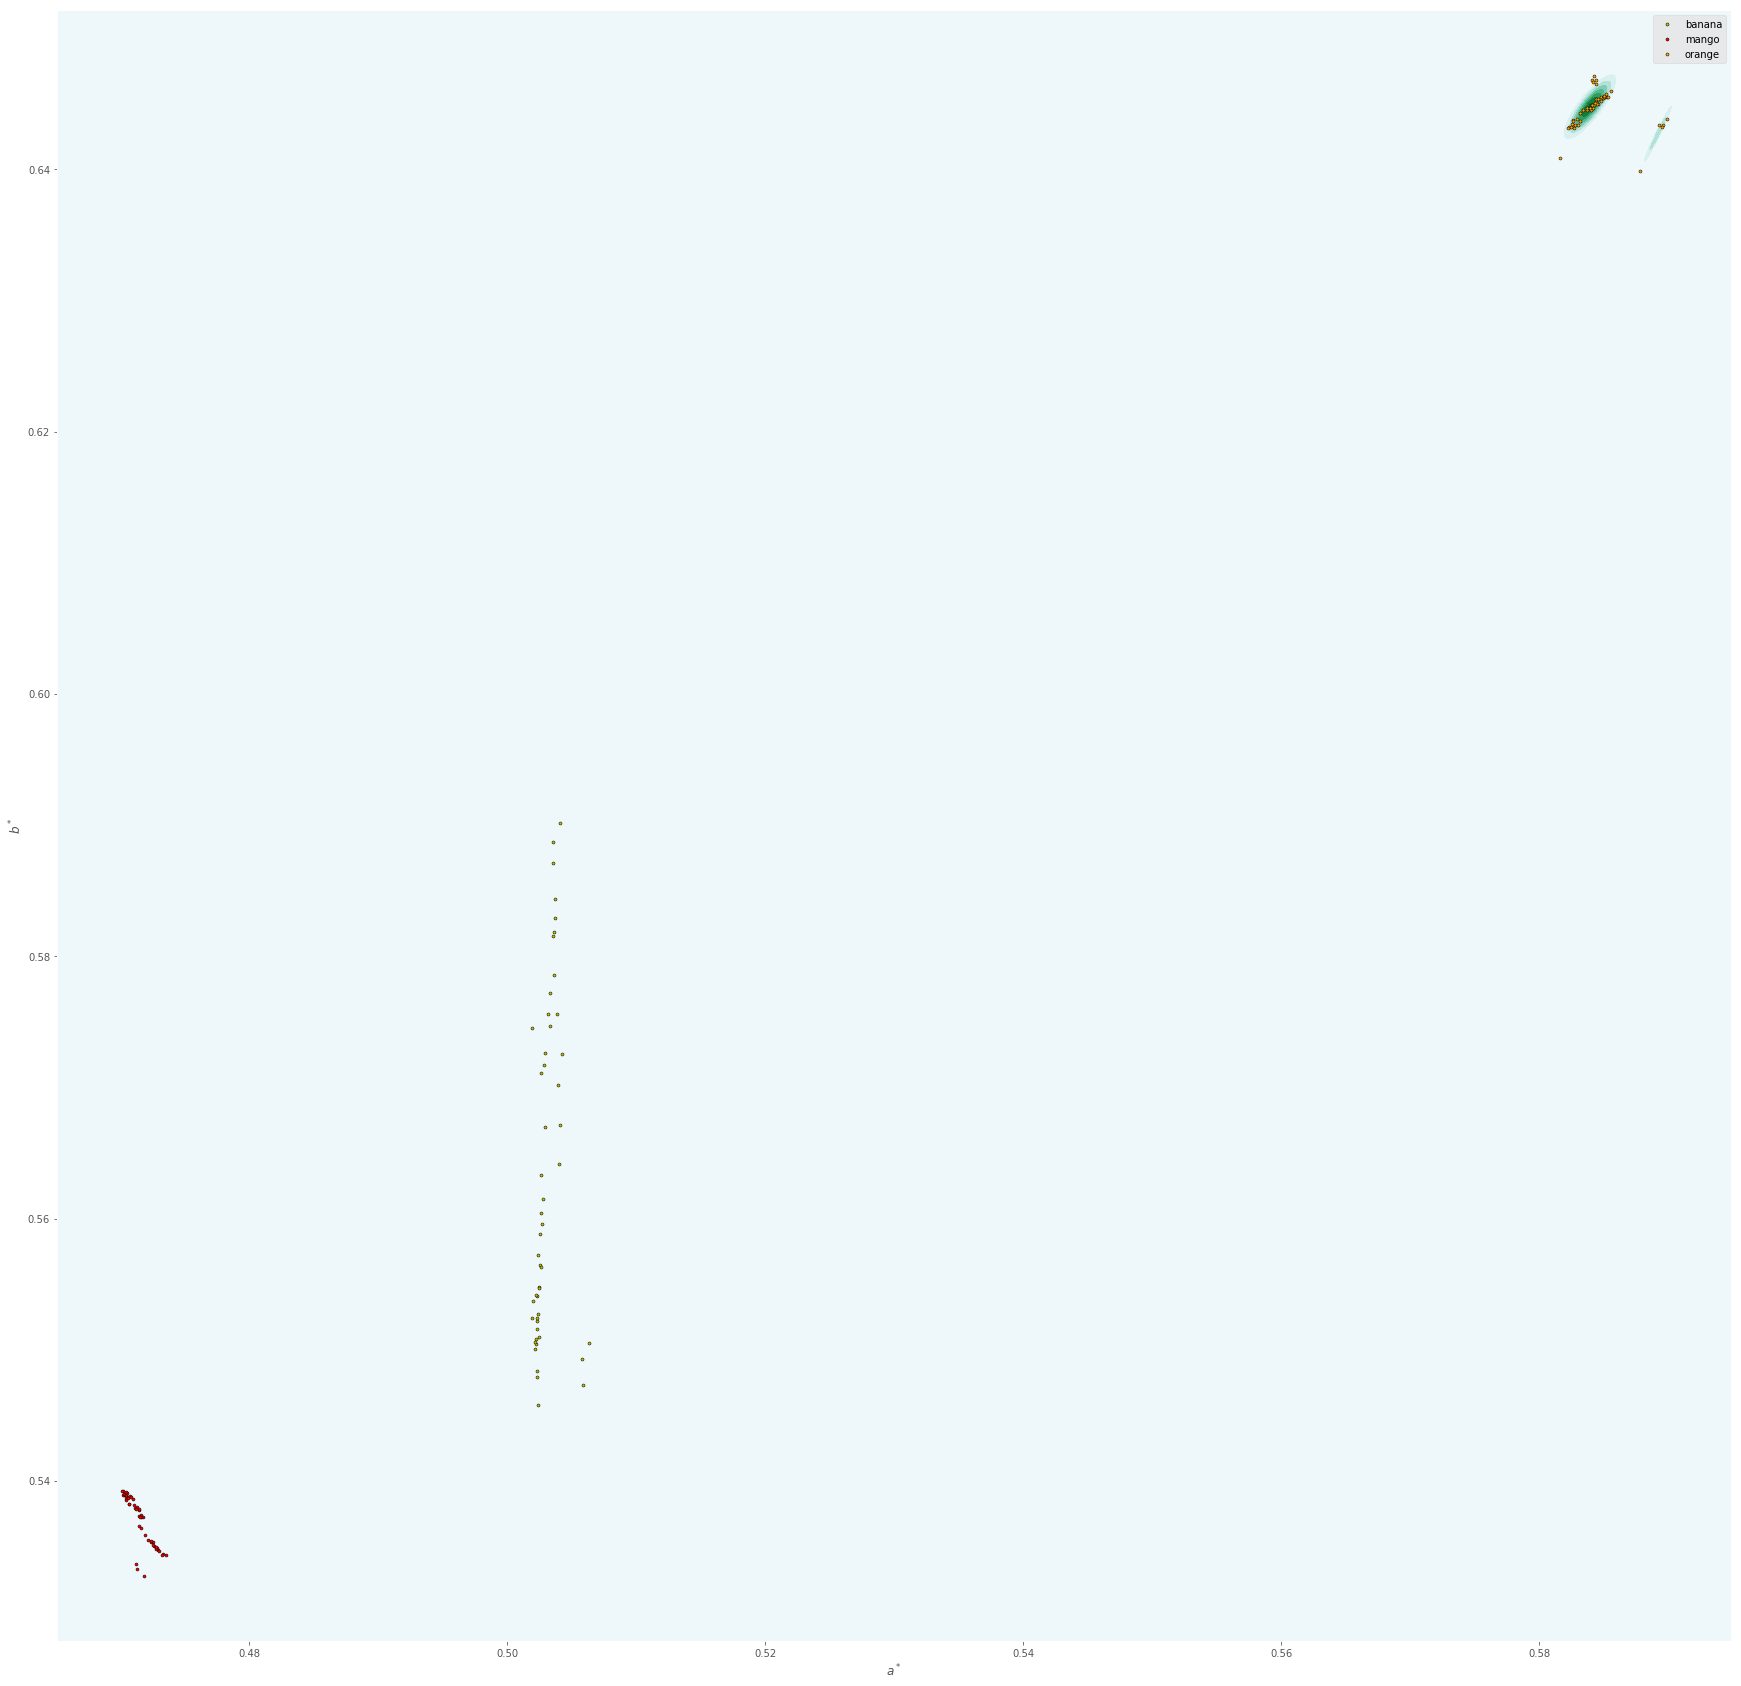

In [14]:
xs = np.linspace(astars.min()-5e-3, astars.max()+5e-3, 5000)
ys = np.linspace(bstars.min()-5e-3, bstars.max()+5e-3, 5000)
X, Y = np.meshgrid(xs, ys)
zs = np.vstack([X.ravel(), Y.ravel()]).T
Z = np.zeros(len(zs))
for p, m, s in zip(em.P, em.theta['mu'], em.theta['cov']):
    Z += p*stats.multivariate_normal(m, s).pdf(zs)
Z = Z.reshape(X.shape)
Z /= Z.size


plt.figure(figsize=(30, 30))
plt.plot(ban_features.T[0], ban_features.T[1], '.', color='y',mec='k', mew=0.5, alpha=1)
plt.plot(man_features.T[0], man_features.T[1], '.', color='r',mec='k', mew=0.5, alpha=1)
plt.plot(ora_features.T[0], ora_features.T[1], '.', color='orange', mec='k', mew=0.5, alpha=1)
plt.legend(['banana', 'mango', 'orange'])
plt.xlabel('$a^*$')
plt.ylabel('$b^*$')
plt.contourf(X, Y, Z, cmap='BuGn')
#plt.colorbar()

# plt.savefig('em_feature_space.png', dpi=300, bbox_inches='tight')
plt.show()
